# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd

from fastai.vision import *
#from fastai.vision.models.xresnet import *

# for datablock API
from fastai.vision.image import _resolve_tfms, _get_crop_target, _round_multiple, _get_resize_target, _affine_grid, _grid_sample, _affine_mult

In [3]:
from fastai.callbacks import * #CSVLogger, ReduceLROnPlateauCallback, SaveModelCallback

In [4]:
from nb_new_data_augmentation_adacos import *

In [5]:
from efficientnet_pytorch import *

In [6]:
import pdb

In [7]:
from ranger import *

In [8]:
__version__

'1.0.57'

# 6D image test

In [9]:
class Image6D(Image):
    "Support applying transforms to image data in `px`."
    def __init__(self, px:Tensor):
        self._px = px
        self._logit_px=None
        self._flow=None
        self._affine_mat=None
        self.sample_kwargs = {}

    def _repr_image_format(self, format_str):
        with BytesIO() as str_buffer:
            #plt.imsave(str_buffer, image2np(self.px[:3]), format=format_str)
            plt.imsave(str_buffer, 
                       np.concatenate((image2np(self.px[:3]), 
                                       image2np(self.px[3:])), axis=1),
                       format=format_str)
            return str_buffer.getvalue()

In [10]:
def open_image_6D(fn:PathOrStr, div:bool=True, convert_mode:str='L', cls:type=Image6D,
        after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        
        x = []
        for i in range(6):
            c = PIL.Image.open(fn+'_w'+str(i+1)+'.png').convert(convert_mode)
            if after_open: c = after_open(c)
            c = np.asarray(c)
            c = torch.from_numpy(c.astype(np.float32, copy=False))
            x.append(c)
            
    x = torch.stack(x)
    if div: x.div_(255)
    return cls(x)

In [11]:
#PATH_trunc = 'train/HEPG2-01/Plate1/B02_s1' # path is missing suffix "_w1.png"
#open_image_6D(PATH_trunc)

# Dataset setup

In [12]:
class ImageList6D(ImageList): #ImageList
    def __init__(self, *args, convert_mode='L', after_open:Callable=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.convert_mode,self.after_open = convert_mode,after_open
        self.copy_new.append('convert_mode')
        self.c,self.sizes = 6,{}
        
    def open(self, fn):
        "Open image in `fn`, subclass and overwrite for custom behavior."
        return open_image_6D(fn, convert_mode=self.convert_mode, after_open=self.after_open)

#    def show(self, img):
#        #return torch.cat((img[i][:3], img[i][3:]), dim=1)
#        show_image(img)
    
    # https://docs.fast.ai/tutorial.itemlist.html#Advanced-show-methods
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(15,10), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            #xs[i].show(ax=ax, y=ys[i], **kwargs)
            img = Image6D(torch.cat((xs[i].data[:3], xs[i].data[3:]), dim=2)) # works but not elegant?
            #img = Image6D(xs[i]) # does not work?
            img.show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

## Full dataset

### Dataset raw files

In [13]:
df_train = pd.read_csv('full_train_dataset_valid-split-ex_v2_20190727.csv', index_col=0)
df_test = pd.read_csv('full_test_dataset_v2_20190727.csv', index_col=0)

In [14]:
df_train.shape

(73030, 5)

In [15]:
df_train.tail()

,path,experiment,sirna,multi,valid
36510,U2OS-03/Plate4/O19_s2,U2OS-03,103,U2OS-03 103,1
36511,U2OS-03/Plate4/O20_s2,U2OS-03,202,U2OS-03 202,1
36512,U2OS-03/Plate4/O21_s2,U2OS-03,824,U2OS-03 824,1
36513,U2OS-03/Plate4/O22_s2,U2OS-03,328,U2OS-03 328,1
36514,U2OS-03/Plate4/O23_s2,U2OS-03,509,U2OS-03 509,1


In [16]:
df_test.tail()

,path,experiment
19892,U2OS-05/Plate4/O19_s2,U2OS-05
19893,U2OS-05/Plate4/O20_s2,U2OS-05
19894,U2OS-05/Plate4/O21_s2,U2OS-05
19895,U2OS-05/Plate4/O22_s2,U2OS-05
19896,U2OS-05/Plate4/O23_s2,U2OS-05


### Color augmentation transformation

"Color Augmentation: Color variability can be increased by applying random color transformations to original training samples. We perform color augmentation by transforming every color channels Ic ← ac · Ic + bc, where ac and bc are drawn from uniform distributions ac ∼ U [0.9, 1.1] and bc ∼ U [−10, +10]." from Domain-adversarial neural networks to address the appearance variability of histopathology images

In [17]:
# from https://github.com/fastai/fastai/blob/master/fastai/vision/transform.py#L137
#def _rgb_randomize(x, channel:int=None, thresh:float=0.3):
#    "Randomize one of the channels of the input image"
#    if channel is None: channel = np.random.randint(0, x.shape[0] - 1)
#    x[channel] = torch.rand(x.shape[1:]) * np.random.uniform(0, thresh)
#    return x
#
#rgb_randomize = TfmPixel(_rgb_randomize)

In [18]:
# Scaling factor comes from byte tensor?
#10/255 = 0.0392156862745098

In [19]:
def _color_augmentation(x):
    "Randomize all channels of the input image"
    channel_count = x.shape[0] - 1
    
    # by transforming every color channels Ic ← ac · Ic + bc, 
    # where ac and bc are drawn from uniform distributions 
    # ac ∼ U [0.9, 1.1] and 
    # bc ∼ U [−10, +10].
    
    # x [0,1]
    
    for c in range(channel_count):
        #pdb.set_trace()
        #print(x.min(), x.max())
        ac = np.random.uniform(0.9, 1.1) #np.random.uniform(0.9, 1.1)
        bc = np.random.uniform(-0.1,0.1) #np.random.uniform(-10, 10)
        x[c] = x[c] * ac + bc
        
        # clipping to min 0 and max 1
        x[c] = torch.clamp(x[c], 0., 1.)
    
    return x

color_augmentation = TfmPixel(_color_augmentation)

### Transforms setup

In [20]:
7982/1405

5.681138790035587

In [21]:
## EfficientNet-B3
#sz, bs = 300, 8 # 4167MiB /  7952MiB
#sz, bs = 300, 8*2 # 78??MiB /  7952MiB // FP16: 4397MiB /  7952MiB
#sz, bs = 300, 8*4 # FP16: 7805MiB /  7952MiB

# EfficientNet-B4
#sz, bs = 380, 8*6 # FP16 FOR HEAD PRETRAINING
#sz, bs = 380, 8  # CUDA ERROR!
sz, bs = 380, 7  # CUDA ERROR!

In [22]:
sz, bs

(380, 7)

In [23]:
# normal tfms
#tfms = get_transforms()

In [24]:
# extended tfms
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_rotate=90.0, max_zoom=1.1, 
                      max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, p_lighting=0.75, 
                      xtra_tfms=[color_augmentation()])

# crop_pad: https://forums.fast.ai/t/misc-issues/35386/10

In [25]:
# extended tfms
#tfms = get_transforms(do_flip=True, flip_vert=True, 
#                      max_rotate=90.0, max_zoom=1.1, 
#                      max_lighting=0.2, max_warp=0.2, 
#                      p_affine=0.75, p_lighting=0.75, 
#                      xtra_tfms=[color_augmentation(), 
#                                 cutout(n_holes=(1,4), length=(10, 100), p=.75)])

In [26]:
# "crop_pad" to sz
tfms[0][0] = crop_pad(size=sz, row_pct=[0.,1.], col_pct=[0.,1.])
tfms[1][0] = crop_pad(size=sz, row_pct=[0.,1.], col_pct=[0.,1.])

### Dataset definition

In [27]:
# VALID SPLIT (incl. tfms)
data = (ImageList6D.from_df(df_train, path='train')
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-3)
        .add_test(ImageList6D.from_df(df_test, path='test'))
        .transform(tfms, size=sz) # remove size so we get the crop size!
        .databunch(bs=bs))

In [28]:
# FULL DATASET (incl. tfms)
#data = (ImageList6D.from_df(df_train, path='train')
#        .split_none() # !!!
#        .label_from_df(cols=-3)
#        .add_test(ImageList6D.from_df(df_test, path='test'))
#        .transform(tfms, size=sz)
#        .databunch(bs=bs))

In [29]:
# VALID SPLIT PREDICTION (NO tfms)
#data = (ImageList6D.from_df(df_train, path='train')
#        .split_from_df(col=-1) 
#        .label_from_df(cols=-3) # label_delim=' ' for MultiCategoryList !
#        .add_test(ImageList6D.from_df(df_test, path='test'))
#        .transform(size=sz) # !!!
#        .databunch(bs=bs))

In [30]:
# FULL DATASET PREDICTION (NO tfms)
#data = (ImageList6D.from_df(df_train, path='train')
#        .split_none() # !!!
#        .label_from_df(cols=-3)
#        .add_test(ImageList6D.from_df(df_test, path='test'))
#        .transform(size=sz)
#        .databunch(bs=bs))

In [31]:
#data.batch_stats()

In [32]:
# From https://github.com/recursionpharma/rxrx1-utils/blob/master/rxrx/main.py
# The mean and stds for each of the channels
GLOBAL_PIXEL_STATS = (np.array([6.74696984, 14.74640167, 10.51260864,
                                10.45369445,  5.49959796, 9.81545561]),
                       np.array([7.95876312, 12.17305868, 5.86172946,
                                 7.83451711, 4.701167, 5.43130431]))

stats_mean = torch.tensor(GLOBAL_PIXEL_STATS[0]/255).float()
stats_var = torch.tensor(GLOBAL_PIXEL_STATS[1]/255).float()

In [33]:
#stats_mean, stats_var

In [34]:
data.normalize([stats_mean, stats_var]);

In [35]:
#data.batch_stats()

In [36]:
data.batch_size

7

In [37]:
#data.stats # results is copied below
#[tensor([0.0456, 0.0702, 0.0447, 0.0468, 0.0407, 0.0399]),
# tensor([0.0644, 0.0733, 0.0536, 0.0633, 0.0555, 0.0392])]

In [38]:
#data

In [39]:
data.c, len(data.classes), data.classes[-5:]

(1108, 1108, [1103, 1104, 1105, 1106, 1107])

In [40]:
data.train_ds[0]

(Image6D (6, 380, 380), Category 513)

In [41]:
#data.classes

In [42]:
data.train_ds[0][1], data.train_ds[0][1].data

(Category 513, 513)

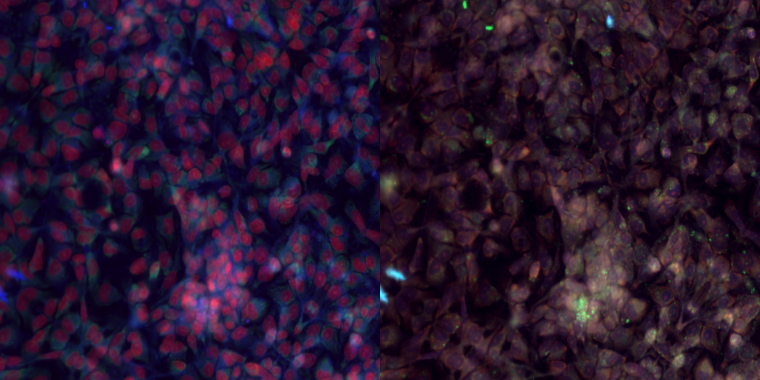

In [43]:
data.train_ds[0][0]

In [44]:
data.train_ds[0][0].data.shape

torch.Size([6, 380, 380])

In [45]:
#data.train_ds[0][0].apply_tfms(crop(size=300, row_pct=(0,1), col_pct=(0,1)))

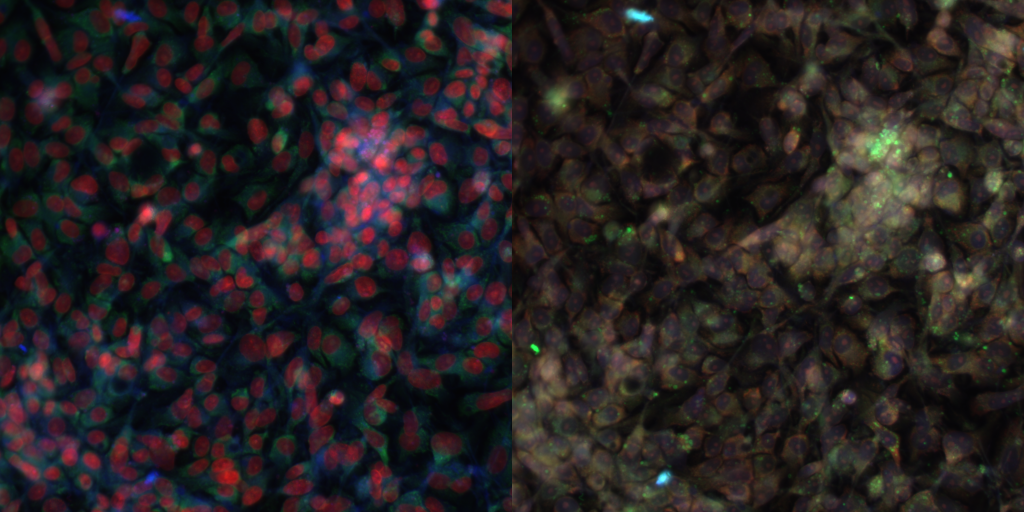

In [46]:
### ORIGINAL 512px NO TFMS
data.train_ds.x[0] #.data.shape

### Adversarial full dataset

In [47]:
data_a = (ImageList6D.from_df(df_train, path='train') # SET CORRECT DF!!!
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-2, label_delim=' ') # label_delim=' ' for MultiCategoryList !
        .add_test(ImageList6D.from_df(df_train, path='train'))
        .transform(tfms, size=sz) # .transform(size=sz)
        .databunch(bs=bs))

In [48]:
data_a

ImageDataBunch;

Train: LabelList (57554 items)
x: ImageList6D
Image6D (6, 380, 380),Image6D (6, 380, 380),Image6D (6, 380, 380),Image6D (6, 380, 380),Image6D (6, 380, 380)
y: MultiCategoryList
HEPG2-01;513,HEPG2-01;840,HEPG2-01;1020,HEPG2-01;254,HEPG2-01;144
Path: train;

Valid: LabelList (15476 items)
x: ImageList6D
Image6D (6, 380, 380),Image6D (6, 380, 380),Image6D (6, 380, 380),Image6D (6, 380, 380),Image6D (6, 380, 380)
y: MultiCategoryList
352,361,503,505,70
Path: train;

Test: LabelList (73030 items)
x: ImageList6D
Image6D (6, 380, 380),Image6D (6, 380, 380),Image6D (6, 380, 380),Image6D (6, 380, 380),Image6D (6, 380, 380)
y: EmptyLabelList
,,,,
Path: train

In [49]:
data_a.c, len(data_a.classes), data_a.classes[-5:]

(1134, 1134, ['RPE-03', 'RPE-04', 'RPE-05', 'U2OS-01', 'U2OS-02'])

In [50]:
data_a.batch_size

7

In [51]:
data_a.train_ds[0]

(Image6D (6, 380, 380), MultiCategory HEPG2-01;513)

In [52]:
#data_a.classes

In [53]:
data_a.train_ds[0][1], data_a.train_ds[0][1].data

(MultiCategory HEPG2-01;513,
 array([0., 0., 0., 0., ..., 0., 0., 0., 0.], dtype=float32))

In [54]:
data_a.train_ds[0][1].data.sum()

2.0

In [55]:
np.where(data_a.train_ds[0][1].data > 0.5)

(array([ 569, 1108]),)

In [56]:
[data_a.classes[j] for j in np.where(data_a.train_ds[0][1].data > 0.5)[0]]

['513', 'HEPG2-01']

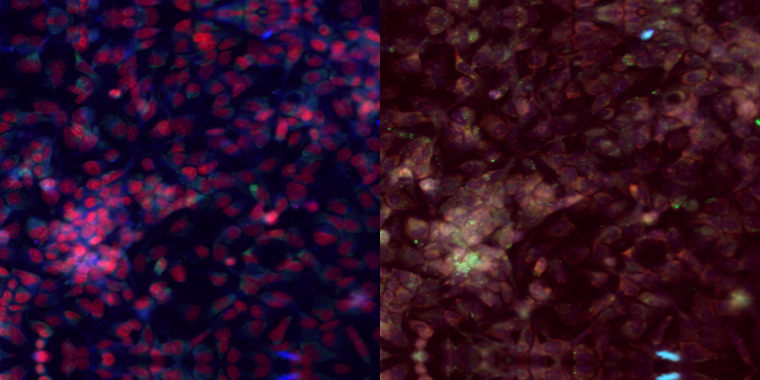

In [57]:
data_a.train_ds[0][0]

In [58]:
# DOES NOT WORK?
#data_a.train_ds[0][0].show()

# Model setup

## EfficientNet

In [59]:
# 3d to 6d from old/rcic_multicat_v9_resnet50-pretrained_colaug.ipynb

In [60]:
from efficientnet_pytorch.utils import get_same_padding_conv2d, round_filters, round_repeats#, relu_fn
from efficientnet_pytorch.model import MBConvBlock, load_pretrained_weights

In [61]:
#??MBConvBlock

In [62]:
#??relu_fn

In [63]:
# From https://github.com/sdoria/mish/blob/master/mish.py
#class Mish(nn.Module):
#    def __init__(self):
#        super().__init__()
#
#    def forward(self, x):
#        x = x*(torch.tanh(F.softplus(x)))
#        return x

In [64]:
# replace ReLU with Mish activation
def relu_fn(x):
    """ Mish activation function """
    return x*(torch.tanh(F.softplus(x)))

In [65]:
# put feature extractor into forward method
class EfficientNet(nn.Module):
    """
    An EfficientNet model. Most easily loaded with the .from_name or .from_pretrained methods
    Args:
        blocks_args (list): A list of BlockArgs to construct blocks
        global_params (namedtuple): A set of GlobalParams shared between blocks
    Example:
        model = EfficientNet.from_pretrained('efficientnet-b0')
    """

    def __init__(self, blocks_args=None, global_params=None):
        super().__init__()
        assert isinstance(blocks_args, list), 'blocks_args should be a list'
        assert len(blocks_args) > 0, 'block args must be greater than 0'
        self._global_params = global_params
        self._blocks_args = blocks_args

        # Get static or dynamic convolution depending on image size
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        # Batch norm parameters
        bn_mom = 1 - self._global_params.batch_norm_momentum
        bn_eps = self._global_params.batch_norm_epsilon

        # Stem
        in_channels = 3  # rgb
        out_channels = round_filters(32, self._global_params)  # number of output channels
        self._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        self._bn0 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Build blocks
        self._blocks = nn.ModuleList([])
        for block_args in self._blocks_args:

            # Update block input and output filters based on depth multiplier.
            block_args = block_args._replace(
                input_filters=round_filters(block_args.input_filters, self._global_params),
                output_filters=round_filters(block_args.output_filters, self._global_params),
                num_repeat=round_repeats(block_args.num_repeat, self._global_params)
            )

            # The first block needs to take care of stride and filter size increase.
            self._blocks.append(MBConvBlock(block_args, self._global_params))
            if block_args.num_repeat > 1:
                block_args = block_args._replace(input_filters=block_args.output_filters, stride=1)
            for _ in range(block_args.num_repeat - 1):
                self._blocks.append(MBConvBlock(block_args, self._global_params))

        # Head
        in_channels = block_args.output_filters  # output of final block
        out_channels = round_filters(1280, self._global_params)
        self._conv_head = Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Final linear layer
        #self._dropout = self._global_params.dropout_rate
        #self._fc = nn.Linear(out_channels, self._global_params.num_classes)

    def forward(self, inputs):
        """ Returns output of the final convolution layer """

        # Stem
        x = relu_fn(self._bn0(self._conv_stem(inputs)))

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)
            x = block(x, drop_connect_rate=drop_connect_rate)

        # Head
        x = relu_fn(self._bn1(self._conv_head(x)))

        return x

    #def forward(self, inputs):
    #    """ Calls extract_features to extract features, applies final linear layer, and returns logits. """
    #
    #    # Convolution layers
    #    x = self.extract_features(inputs)
    #
    #    # Pooling and final linear layer
    #    x = F.adaptive_avg_pool2d(x, 1).squeeze(-1).squeeze(-1)
    #    if self._dropout:
    #        x = F.dropout(x, p=self._dropout, training=self.training)
    #    x = self._fc(x)
    #    return x

    @classmethod
    def from_name(cls, model_name, override_params=None):
        cls._check_model_name_is_valid(model_name)
        blocks_args, global_params = get_model_params(model_name, override_params)
        return EfficientNet(blocks_args, global_params)

    @classmethod
    def from_pretrained(cls, model_name, num_classes=1000):
        model = EfficientNet.from_name(model_name, override_params={'num_classes': num_classes})
        load_pretrained_weights(model, model_name, load_fc=(num_classes == 1000))
        return model

    @classmethod
    def get_image_size(cls, model_name):
        cls._check_model_name_is_valid(model_name)
        _, _, res, _ = efficientnet_params(model_name)
        return res

    @classmethod
    def _check_model_name_is_valid(cls, model_name, also_need_pretrained_weights=False):
        """ Validates model name. None that pretrained weights are only available for
        the first four models (efficientnet-b{i} for i in 0,1,2,3) at the moment. """
        num_models = 4 if also_need_pretrained_weights else 8
        valid_models = ['efficientnet_b'+str(i) for i in range(num_models)]
        if model_name.replace('-','_') not in valid_models:
            raise ValueError('model_name should be one of: ' + ', '.join(valid_models))

In [66]:
from torch.utils import model_zoo

In [67]:
url_map = {
    'efficientnet-b0': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b0-355c32eb.pth',
    'efficientnet-b1': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b1-f1951068.pth',
    'efficientnet-b2': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b2-8bb594d6.pth',
    'efficientnet-b3': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b3-5fb5a3c3.pth',
    'efficientnet-b4': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b4-6ed6700e.pth',
    'efficientnet-b5': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b5-b6417697.pth',
    'efficientnet-b6': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b6-c76e70fd.pth',
    'efficientnet-b7': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b7-dcc49843.pth',
}

In [68]:
# adapt load function to only load weights for feature extractor stage
def load_pretrained_weights(model, model_name, load_fc=True):
    """ Loads pretrained weights, and downloads if loading for the first time. """
    state_dict = model_zoo.load_url(url_map[model_name])
    #if load_fc:
    #    model.load_state_dict(state_dict)
    #else:
    state_dict.pop('_fc.weight')
    state_dict.pop('_fc.bias')
    res = model.load_state_dict(state_dict, strict=False)
        #assert str(res.missing_keys) == str(['_fc.weight', '_fc.bias']), 'issue loading pretrained weights'
    print('Loaded pretrained weights for {}'.format(model_name))

In [69]:
# b3: input size = 300
#efficientnet_b3 = EfficientNet.from_name('efficientnet-b3')
efficientnet_f = EfficientNet.from_pretrained('efficientnet-b4')

Loaded pretrained weights for efficientnet-b4


In [70]:
efficientnet_f

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [71]:
efficientnet_f._conv_stem, type(efficientnet_f._conv_stem)

(Conv2dStaticSamePadding(
   3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
   (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
 ), efficientnet_pytorch.utils.Conv2dStaticSamePadding)

In [72]:
utils.Conv2dStaticSamePadding(6, 48, kernel_size=(3, 3), stride=(2, 2), bias=False, image_size=sz)

Conv2dStaticSamePadding(
  6, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
  (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
)

In [73]:
p_dict = {pn: p for pn, p in efficientnet_f._conv_stem.named_parameters()}

In [74]:
p_dict.keys()

dict_keys(['weight'])

In [75]:
p_dict['weight'].shape, p_dict['weight'].requires_grad

(torch.Size([48, 3, 3, 3]), True)

In [76]:
old_weight = p_dict['weight'].detach()

In [77]:
old_weight.shape, old_weight.requires_grad

(torch.Size([48, 3, 3, 3]), False)

In [78]:
new_weight = torch.cat((old_weight, old_weight), dim=1)

In [79]:
new_weight.shape, new_weight.requires_grad

(torch.Size([48, 6, 3, 3]), False)

In [80]:
def show_input_stage_weights(weight=None, nrows=2, ncols=3):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
    k = 0
    for i in range(nrows):
        for j in range(ncols):
            if nrows > 1:
                ax[i,j].set_title(k)
                ax[i,j].imshow(weight[0][k])
                ax[i,j].axis("off")
            else:
                ax[j].set_title(k)
                ax[j].imshow(weight[0][k])
                ax[j].axis("off")
            k += 1

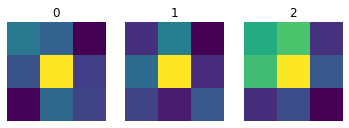

In [81]:
# plot old_weight
show_input_stage_weights(old_weight, nrows=1)

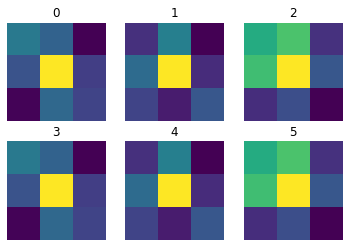

In [82]:
# plot new_weight
show_input_stage_weights(new_weight)

In [83]:
# replace first conv layer with a 6-channel version
efficientnet_f._conv_stem = utils.Conv2dStaticSamePadding(6, 48, kernel_size=(3, 3),
                                                           stride=(2, 2), bias=False, image_size=sz)

In [84]:
efficientnet_f._conv_stem

Conv2dStaticSamePadding(
  6, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
  (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
)

In [85]:
efficientnet_f._conv_stem.weight.shape

torch.Size([48, 6, 3, 3])

In [86]:
# set new_weights to nn.Parameter and overwrite it in the conv layer
efficientnet_f._conv_stem.weight = nn.Parameter(new_weight) # hand over requires_grad False?

In [87]:
# check if weight was loaded properly
assert torch.allclose(new_weight, efficientnet_f._conv_stem.weight)

In [88]:
efficientnet_f._conv_stem.weight.shape, efficientnet_f._conv_stem.weight.requires_grad

(torch.Size([48, 6, 3, 3]), True)

In [89]:
# network is in full train mode!
#[p.requires_grad for p in efficientnet_b3f.parameters()]

In [90]:
def set_rg(model=efficientnet_f, option=False):
    for param in model.parameters():
        param.requires_grad = option

In [91]:
set_rg()

In [92]:
# network is frozen
#[p.requires_grad for p in efficientnet_b3f.parameters()]

In [93]:
efficientnet_f._conv_stem.weight.requires_grad

False

In [94]:
# set input stage to trainable
#efficientnet_f._conv_stem.weight.requires_grad = True

In [95]:
efficientnet_f._conv_stem.weight.requires_grad

False

In [96]:
efficientnet_f(torch.randn(1,6,sz,sz)).shape

torch.Size([1, 1792, 11, 11])

### AdaCos-Head

In [97]:
def create_adacos_head(nf:int, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5,
                concat_pool:bool=True, bn_final:bool=False):
    #nc:int, 
    "Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes."
    
    lin_ftrs = [nf, 512, 512] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    # remove last 512 fc layer to reduce MODEL SIZE ??? ???
    
    ps = listify(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    layers = [pool, Flatten()]
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += bn_drop_lin(ni, no, True, p, actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    #layers.append(AdaCos(lin_ftrs[-1], nc))
    return nn.Sequential(*layers)

In [98]:
adacos_head = create_adacos_head(nf=1792*2)

In [99]:
adacos_head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(3584, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=3584, out_features=512, bias=True)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=512, bias=True)
)

In [100]:
adacos_head(torch.randn(2, 1792, 9, 9)).shape

torch.Size([2, 512])

In [101]:
# from https://github.com/4uiiurz1/pytorch-adacos/blob/master/metrics.py
class AdaCos(nn.Module):
    def __init__(self, num_features, num_classes, m=0.50):
        super(AdaCos, self).__init__()
        self.num_features = num_features
        self.n_classes = num_classes
        self.s = math.sqrt(2) * math.log(num_classes - 1)
        self.m = m
        self.W = nn.Parameter(torch.FloatTensor(num_classes, num_features))
        nn.init.xavier_uniform_(self.W)

    def forward(self, xb, yb):
        
        #print(yb.shape)
        #pdb.set_trace()
        
        # normalize features
        x = F.normalize(xb)
        # normalize weights
        W = F.normalize(self.W)
        # dot product
        logits = F.linear(x, W)
        
        # for training in non-AdaCos mode (= no yb date in the forward pass):
        if yb is None:
            print('yb = None')
            return logits
        
        # feature re-scale
        theta = torch.acos(torch.clamp(logits, -1.0 + 1e-7, 1.0 - 1e-7))
        one_hot = torch.zeros_like(logits)
        
        # ORIGINAL
        #one_hot.scatter_(1, yb.view(-1, 1).long(), 1)
        #with torch.no_grad():
        #    B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
        #    B_avg = torch.sum(B_avg) / xb.size(0)
        #    #print(B_avg)
        #    theta_med = torch.median(theta[one_hot == 1])
        #    self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
        #    #print(self.s)
            
        # ADAPTED FOR CUTMIX TO GET MIXED SCALE PARAMETER
        with torch.no_grad():
            # FROM nb_new_data_augmentation_adacos2.py LINE 888
            # AND https://github.com/fastai/fastai/blob/master/fastai/callbacks/mixup.py#L40
            if yb.ndim == 2:# and target.shape[-1] >1:
                n_mod_patches = (yb.shape[-1] - 1) // 2
                #c_ = yb[:, 1:n_mod_patches + 1]
                c_ = yb[:, 0:n_mod_patches + 1]
                W_ = yb[:, n_mod_patches + 1:]
                self.s_scaled = []
                
                # this loop is only realdy needed when we have different probabilities inside a batch
                # which we do not have (right now)! So this could be cleaned up, but we leave until
                # we know we will not need the case with different probabilities in a batch.
                for k in range(n_mod_patches+1):
                    yb_new = c_[:, k].long()
                    #pdb.set_trace()
                    
                    one_hot.scatter_(1, yb_new.view(-1,1).long(), 1)
                    
                    B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
                    B_avg = torch.sum(B_avg) / xb.size(0)
                    theta_med = torch.median(theta[one_hot == 1])
                    self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
                    
                    if k+1 == len(range(n_mod_patches+1)):
                        #self.s_scaled.append((1-W_[:, k-1]) * self.s)
                        self.s_scaled.append((1-W_[0, k-1]) * self.s)
                        # For more than two the sum of W_[:, :k] has to be used!!!
                    else:
                        #self.s_scaled.append(W_[:, k] * self.s)
                        self.s_scaled.append(W_[0, k] * self.s)
                    # Mixed B_avg & self.s and single are not really far off, but now we have it coded
                    # se we keep it (until it breaks something later).
                self.s = torch.add(*self.s_scaled)
                # Clean up, self.s_scaled is just a vector with the same entry multiple times
                # when it is not indexed above with W_[0,... !
            else:
                one_hot.scatter_(1, yb.view(-1,1).long(), 1)
                B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
                B_avg = torch.sum(B_avg) / xb.size(0)
                theta_med = torch.median(theta[one_hot == 1])
                self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
        
        output = self.s * logits

        return output

In [102]:
class AdaCosNet(nn.Module):
    '''Simple AdaCosNet connecter to run xb through the feature extractor head
    and then feed xb and yb into the AdaCos layer.'''
    def __init__(self, body, head):
        super(AdaCosNet, self).__init__()
        self.body = body
        self.head = head
        self.adacos = AdaCos(512, 1108)
        
    def forward(self, xb, yb=None): # yb=None for training in non-AdaCos mode!
        features = self.body(xb)
        out = self.head(features)
        #print('xb.shape: ', xb.shape,', yb.shape: ', yb.shape)
        out = self.adacos(out, yb)
        #print('out: ',out.shape)
        #pdb.set_trace()
        return out

In [103]:
adacos_efficientnet = AdaCosNet(efficientnet_f, adacos_head)

In [104]:
adacos_efficientnet(torch.randn(2,6,sz,sz)).shape

yb = None


torch.Size([2, 1108])

In [105]:
adacos_efficientnet(torch.randn(2,6,sz,sz), torch.tensor([513, 1])).shape

torch.Size([2, 1108])

In [106]:
test_target = torch.tensor(
    [[2.4700e+02, 3.3900e+02, 7.8362e-01],
     [2.3300e+02, 7.7400e+02, 7.8362e-01],
     [7.7400e+02, 1.3400e+02, 7.8362e-01],
     [6.9800e+02, 8.4700e+02, 7.8362e-01]])

In [107]:
adacos_efficientnet(torch.randn(4,6,sz,sz), test_target).shape

torch.Size([4, 1108])

In [108]:
# Based on https://forums.fast.ai/t/teacher-forcing/29415/4
# https://forums.fast.ai/t/on-batch-begin-callback/35201/3
@dataclass
class AppendBatchTargs(Callback):
    learn:Learner
    def __init__(self, learn):
        super().__init__()
    def on_batch_begin(self, last_input, last_target, **kwargs):
        return {'last_input':(last_input, last_target), 'last_target':last_target}

# Training

## adacos_efficientnet_b4

In [109]:
#opt_func = partial(Ranger, betas=(0.95,0.99), eps=1e-6)
opt_func = partial(Ranger, betas=(0.95,0.99), eps=1e-4) # FP16 !!!

In [110]:
learn = Learner(data, adacos_efficientnet, wd=1e-2, opt_func=opt_func,
               bn_wd=False, true_wd=True, loss_func=LabelSmoothingCrossEntropy(),
               metrics=[accuracy], callback_fns=[AppendBatchTargs])#.to_fp16()

In [111]:
#learn = Learner(data, adacos_efficientnet, metrics=[accuracy],
#                callback_fns=[CSVLogger, AppendBatchTargs])#.to_fp16() 

In [112]:
#adacos_efficientnet

In [113]:
#[adacos_efficientnet.body._blocks[i] for i in range(31)]

In [114]:
#learn.model

In [115]:
# generate layer groups for discriminative layer training
# https://docs.fast.ai/basic_train.html#Discriminative-layer-training
learn.split((adacos_efficientnet.body._conv_stem,
             #adacos_efficientnet.body._blocks, # all blocks as a layer group
             *[adacos_efficientnet.body._blocks[i] for i in range(31)], # put in each block in
             adacos_efficientnet.body._conv_head,
             adacos_efficientnet.head,
             adacos_efficientnet.adacos
            ));

In [116]:
# we have 30 layer groups!
len(learn.lr_range(slice(1e-5,1e-3)))

35

In [117]:
#learn.save('adacos_efficientnet_b3_pretrained_6d-input')

In [118]:
#learn.load('adacos_efficientnet_b3_pretrained_6d-input');

In [119]:
#learn.opt_func

In [120]:
#learn.to_fp16();

In [121]:
# Make Adam FP16 proof:
# https://forums.fast.ai/t/mixed-precision-training/29601/21
# https://discuss.pytorch.org/t/adam-half-precision-nans/1765
# https://vxlabs.com/2019/02/04/improving-fastais-mixed-precision-support-with-nvidias-automatic-mixed-precision/
#learn.opt_func = partial(learn.opt_func, eps=1e-4)
#learn.opt_func

### ADD CLIP PARAMETER TOO???

In [122]:
learn.loss_func

LabelSmoothingCrossEntropy()

In [123]:
#learn.layer_groups

In [124]:
def check_rg(model=learn.model):
    layer_rg = [(n, p.requires_grad) for n,p in model.named_parameters()]
    for i in range(len(layer_rg)):
        print(f'{layer_rg[i][0]}\t{layer_rg[i][1]}'.expandtabs(40))

In [125]:
# unfreeze network
#learn.unfreeze()
#set_rg(learn.model.body, option=True)

In [126]:
check_rg() # check where trainable

body._conv_stem.weight                  False
body._bn0.weight                        False
body._bn0.bias                          False
body._blocks.0._depthwise_conv.weight   False
body._blocks.0._bn1.weight              False
body._blocks.0._bn1.bias                False
body._blocks.0._se_reduce.weight        False
body._blocks.0._se_reduce.bias          False
body._blocks.0._se_expand.weight        False
body._blocks.0._se_expand.bias          False
body._blocks.0._project_conv.weight     False
body._blocks.0._bn2.weight              False
body._blocks.0._bn2.bias                False
body._blocks.1._depthwise_conv.weight   False
body._blocks.1._bn1.weight              False
body._blocks.1._bn1.bias                False
body._blocks.1._se_reduce.weight        False
body._blocks.1._se_reduce.bias          False
body._blocks.1._se_expand.weight        False
body._blocks.1._se_expand.bias          False
body._blocks.1._project_conv.weight     False
body._blocks.1._bn2.weight        

In [127]:
#learn.summary()

In [128]:
def flattenAnneal(learn:Learner, lr:float, n_epochs:int, start_pct:float):
    n = len(learn.data.train_dl)
    anneal_start = int(n*n_epochs*start_pct)
    anneal_end = int(n*n_epochs) - anneal_start
    phases = [TrainingPhase(anneal_start).schedule_hp('lr', lr),
              TrainingPhase(anneal_end).schedule_hp('lr', lr, anneal=annealing_cos)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    learn.fit(n_epochs)

### Pretraining head

In [129]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


ValueError: too many values to unpack (expected 2)

In [ ]:
!rm train/models/tmp.pth

In [ ]:
flattenAnneal(learn, 1e-6, 4, 0.7)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.save('effnet/adacos_efficientnet_b4_e004_pretrain_inp-output_190916')

In [ ]:
learn.load('effnet/adacos_efficientnet_b4_e004_pretrain_inp-output_190916');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
!rm train/models/tmp.pth

In [ ]:
flattenAnneal(learn, 1e-3, 4, 0.7)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.save('effnet/adacos_efficientnet_b4_e008_pretrain_inp-output_190916')

In [ ]:
learn.load('effnet/adacos_efficientnet_b4_e008_pretrain_inp-output_190916');

### Pretraining differential lrs

In [ ]:
learn.unfreeze()
#set_rg(learn.model.body, option=True)

In [ ]:
check_rg() # check where trainable

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
!rm train/models/tmp.pth

In [ ]:
learn.lr_range(slice(1e-8,1e-4))

In [ ]:
lrs = learn.lr_range(slice(1e-8,1e-4))

In [ ]:
flattenAnneal(learn, lrs, 10, 0.7)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.save('effnet/adacos_efficientnet_b4_e018_pretrain_inp-output_190916')

In [ ]:
learn.load('effnet/adacos_efficientnet_b4_e018_pretrain_inp-output_190916');

In [ ]:
# compare initialized input stage to pretrain input stage
show_input_stage_weights(new_weight)

In [ ]:
show_input_stage_weights(learn.model.body._conv_stem.weight)

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
!rm train/models/tmp.pth

In [ ]:
lrs = learn.lr_range(slice(1e-6,1e-4))

In [ ]:
flattenAnneal(learn, lrs, 22, 0.7)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.save('effnet/adacos_efficientnet_b4_e040_pretrain_inp-output_190917')

In [ ]:
learn.load('effnet/adacos_efficientnet_b4_e040_pretrain_inp-output_190917');

In [ ]:
# compare initialized input stage to pretrain input stage
show_input_stage_weights(new_weight)

In [ ]:
show_input_stage_weights(learn.model.body._conv_stem.weight)

In [ ]:
learn.validate()

In [ ]:
learn.unfreeze()

In [ ]:
lrs = learn.lr_range(slice(1e-6,1e-4))

In [ ]:
flattenAnneal(learn, lrs, 6, 0.7)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.save('effnet/adacos_efficientnet_b4_e0X6_pretrain_inp-output_190917')

In [ ]:
learn.load('effnet/adacos_efficientnet_b4_e0X6_pretrain_inp-output_190917');

In [ ]:
flattenAnneal(learn, lrs, 12, 0.7)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.save('effnet/adacos_efficientnet_b4_e0X18_pretrain_inp-output_190917')

In [ ]:
learn.load('effnet/adacos_efficientnet_b4_e0X18_pretrain_inp-output_190917');

### Standard training

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
flattenAnneal(learn, 1e-4, 38, 0.7)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.save('effnet/adacos_efficientnet_b4_Pre018e038_190918')

In [ ]:
learn.load('effnet/adacos_efficientnet_b4_Pre018e038_190918');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
flattenAnneal(learn, 1e-4, 38, 0.7)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.save('effnet/adacos_efficientnet_b4_Pre018e076_190919')

In [132]:
learn.load('effnet/adacos_efficientnet_b4_Pre018e076_190919');

In [ ]:
# RENAME FILE: Were only 26 epochs instead of 38!!! (Val acc. = ~26%)

### CutMix 1-Cycle

In [129]:
learn.load('effnet/adacos_efficientnet_b4_Pre018e076_190919');

In [130]:
learn.unfreeze()

In [131]:
learn.cutmix();

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


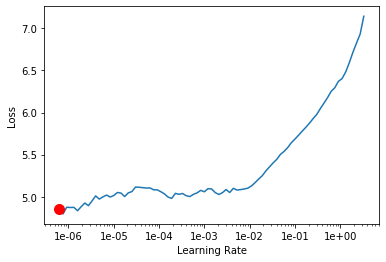

In [132]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
flattenAnneal(learn, 1e-4, 38, 0.7)

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.save('effnet/adacos_efficientnet_b4_Pre018e064CM038_190920')

In [ ]:
learn.load('effnet/adacos_efficientnet_b4_Pre018e064CM038_190920');

### Custom Blend CutMix

In [ ]:
kwargs = {
    'size': .05, 
    'alpha': .2,
    'blend_type': 'zero', 
}

In [ ]:
learn.blend(**kwargs);

In [ ]:
learn.fit_one_cycle(4, 1e-3)

In [ ]:
%debug

In [ ]:
# Define transform function
tfm_fn = partial(blend, blend_type='cut', same_size=False)

#Define schedule parameters
sch_param=['size', 'fixed_proba']
sch_val = [(.05, 2), .2 ]  # You can also enter a list of tuples
sch_iter = [(0., .3), (0., .7)]  # And a tuple with start and end iteration percentage
sch_func = [annealing_cos, partial(cosine_annealing, pct_start=.3)] # options: None = annealing_linear, annealing_cos, cosine_annealing
plot = True
test = True  # if True this will stop training in the first mini-batch
sch_tfm_cb = partial(TfmScheduler, tfm_fn=tfm_fn, sch_param=sch_param, sch_val=sch_val, 
                      sch_iter=sch_iter, sch_func=sch_func, plot=plot, test=test)
learn.callback_fns.append(sch_tfm_cb)

# Submission

## Classifcation

In [ ]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe110_20190729');

In [ ]:
# get prediction of test dataset
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
# check length
len(preds)

In [ ]:
# get the categories
preds_cat = preds.argmax(dim=-1)

In [ ]:
# get the names
preds_names = learn.data.test_ds.x.items

In [ ]:
# without site
#preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3][:3] for x in preds_names]

# with site
preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3] for x in preds_names]

In [ ]:
df_preds = pd.DataFrame({'id_code_site': preds_names, 'sirna': preds_cat})

In [ ]:
# get id_code without site
df_preds['id_code'] = df_preds['id_code_site'].apply(lambda x: x[:-3])

In [ ]:
# get row indices with the same/not the same the prediction for both sites
idx = [] # indices with the same prediction
idx_notsame = [] # indices with not the same prediction
for i, r in enumerate(df_preds.sort_values('id_code').iterrows()):
    if i % 2:
        # distance from row 2 is 
        if pred == r[1]['sirna']:
            idx.append(r[0])
        else:
            #idx.append(r[0]) # always append idx until we come up with something better
            idx.append(idx_row_before)
            idx_notsame.append(idx_row_before) # get the first rows of the pairs that are not the same
    else:
        # save dist from row 1 for comparison in next iteration
        pred = r[1]['sirna']
        idx_row_before = r[0]

In [ ]:
len(idx), len(idx_notsame)

In [ ]:
idx[:5]

In [ ]:
df_preds.sort_values('id_code').head(10)

In [ ]:
#df_preds.loc[idx,['id_code','sirna']]

In [ ]:
# 'effnet/adacos_efficientnet_b3_e080CM112_190805'
model = 'metriclearn_efficientnet_b3_e080CM112_190805'

In [ ]:
df_preds.loc[idx,['id_code','sirna']].to_csv('sub/'+model+'.csv.gz', index=False, compression='gzip')

In [ ]:
!kaggle competitions submit -c recursion-cellular-image-classification -f sub/{model}.csv.gz -m "{model}"


## Cosinus similarity

### Full single features

In [ ]:
# https://github.com/ducha-aiki/whale-identification-2018/blob/master/reproduce_problems.ipynb
# And for test-time augmentation I used following random solution: switch train and val transforms

In [ ]:
# extended tfms
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_rotate=90.0, max_zoom=1.1, 
                      max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, p_lighting=0.75, 
                      xtra_tfms=[color_augmentation()])

# crop_pad: https://forums.fast.ai/t/misc-issues/35386/10

In [ ]:
# extended tfms w/o color_augmentation !!!
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_rotate=90.0, max_zoom=1.1, 
                      max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, p_lighting=0.75)

In [ ]:
# sz, bs = 300, 8*2
sz, bs = 512, 8*3

In [ ]:
# VALID SPLIT (incl. tfms)
data = (ImageList6D.from_df(df_train, path='train')
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-3)
        .add_test(ImageList6D.from_df(df_test, path='test'))
        .transform(tfms)#, size=sz) # remove size so we get the crop size!
        .databunch(bs=bs))

In [ ]:
# Batch-wise normalization should be enough because the deviation is max. 6%
# see "rcic_v10_inspect_image_data.ipynb" for analysis.
#data.normalize() # https://docs.fast.ai/vision.data.html#ImageDataBunch.batch_stats

data.normalize([tensor([0.0456, 0.0702, 0.0447, 0.0468, 0.0407, 0.0399]),
                tensor([0.0644, 0.0733, 0.0536, 0.0633, 0.0555, 0.0392])]);

# efficientnet stats https://github.com/lukemelas/EfficientNet-PyTorch#example-classification
#data.normalize(([0.485, 0.456, 0.406, 0.485, 0.456, 0.406],
#               [0.229, 0.224, 0.225, 0.229, 0.224, 0.225]))

# mean of mean, and mean of std from rcic_v10_inspect_image_data.ipynb
#data.normalize()

In [ ]:
#data.train_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data.train_ds)
#data.train_dl.dl.batch_sampler.drop_last = False
#
#data.valid_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data.valid_ds)
#data.valid_dl.dl.batch_sampler.drop_last = False
#
## DOES WORK TOO FOR TEST DL ??? ??? (Or do we need to set the test dataset to the valid dataset?)
#data.test_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data.test_ds)
#data.test_dl.dl.batch_sampler.drop_last = False

In [ ]:
learn = Learner(data, adacos_efficientnet_b3)

In [ ]:
learn.load('effnet/adacos_efficientnet_b3_e080CM185-230_190807_best')

In [ ]:
def get_feats(model, dataloader, cycles=1):
    feats = []
    targs = []
    model.eval()
    with torch.no_grad():
        for i in range(cycles): # for TTA
            for xb, yb in dataloader:
                body_out = model.body(xb)
                head_out = model.head(body_out)
                feats.append(head_out.cpu())
                targs.append(yb.cpu())
    return feats, targs

#### Train

In [ ]:
feats, targs = get_feats(learn.model, learn.data.train_dl)#, cycles=3)

In [ ]:
len(feats), len(targs)

In [ ]:
# total images: 89*320
learn.data.batch_size * len(learn.data.train_dl)

In [ ]:
#len(learn.data.train_dl), len(learn.data.valid_dl), len(learn.data.test_dl)

In [ ]:
feats = torch.cat(feats, dim=0)
targs = torch.cat(targs, dim=0)

In [ ]:
feats.shape, targs.shape

In [ ]:
np.save('pred/feats_train.npy', feats)
np.save('pred/targs_train.npy', targs)

#### Valid

In [ ]:
feats, targs = get_feats(learn.model, learn.data.valid_dl)

In [ ]:
len(feats), len(targs)

In [ ]:
feats = torch.cat(feats, dim=0)
targs = torch.cat(targs, dim=0)

In [ ]:
feats.shape, feats.shape, targs.shape

In [ ]:
np.save('pred/feats_valid.npy', feats)
np.save('pred/targs_valid.npy', targs)

#### Test

In [ ]:
feats, targs = get_feats(learn.model, learn.data.test_dl)

In [ ]:
del targs

In [ ]:
len(feats)

In [ ]:
feats = torch.cat(feats, dim=0)

In [ ]:
feats.shape

In [ ]:
np.save('pred/feats_test.npy', feats)

### Multi-crop features

In [ ]:
# https://github.com/ducha-aiki/whale-identification-2018/blob/master/reproduce_problems.ipynb
# And for test-time augmentation I used following random solution: switch train and val transforms

In [ ]:
df_train['test'] = 0
df_train['path'] = 'train/'+df_train['path']

In [ ]:
df_train.head()

In [ ]:
# add dummy columns for test dataset
df_test['path'] = 'test/'+df_test['path']
df_test['test'] = 1
df_test['sirna'] = 1

In [ ]:
df_test.head()

In [ ]:
df_train_test = pd.concat((df_train, df_test), axis=0, sort=False)

In [ ]:
df_train_test.tail()

In [ ]:
# reload for train and valid ds
df_train = pd.read_csv('full_train_dataset_valid-split-ex_v2_20190727.csv', index_col=0)
df_test = pd.read_csv('full_test_dataset_v2_20190727.csv', index_col=0)

In [ ]:
# test tfms switching for test ds
#tfms_switched = (tfms[1], tfms[0])
#
#data = (ImageList6D.from_df(df_train_test, path='.')
#                .split_from_df(col=-1)
#                .label_from_df(cols=-4)
#                .transform(tfms_switched)#, size=sz) # remove size so we get the crop size!
#                .databunch(bs=bs))

In [ ]:
#data.train_ds[0][0]

In [ ]:
#data.valid_ds[0][0]

In [ ]:
def get_dataset(row_pct, col_pct, is_test=False):
    # extended tfms
    tfms = get_transforms(do_flip=True, flip_vert=True, 
                          max_rotate=90.0, max_zoom=1.1, 
                          max_lighting=0.2, max_warp=0.2, 
                          p_affine=0.75, p_lighting=0.75, 
                          xtra_tfms=[color_augmentation()])
    
    # change "crop_pad" from get_transforms to "crop"
    tfms[0][0] = crop(size=sz, row_pct=row_pct, col_pct=col_pct)
    tfms[1][0] = crop(size=sz, row_pct=row_pct, col_pct=col_pct)
    
    # VALID SPLIT (incl. tfms)
    if is_test:
        #switch train with valid (= test) tfms!
        tfms_switched = (tfms[1], tfms[0])
        
        data = (ImageList6D.from_df(df_train_test, path='.')
                .split_from_df(col=-1)
                .label_from_df(cols=-4)
                .transform(tfms_switched)#, size=sz) # remove size so we get the crop size!
                .databunch(bs=bs))
    else:
        data = (ImageList6D.from_df(df_train, path='train')
                .split_from_df(col=-1) # split_by_rand_pct()
                .label_from_df(cols=-3)
                #.add_test(ImageList6D.from_df(df_test, path='test'))
                .transform(tfms)#, size=sz) # remove size so we get the crop size!
                .databunch(bs=bs))
    
    data.normalize([tensor([0.0456, 0.0702, 0.0447, 0.0468, 0.0407, 0.0399]),
                    tensor([0.0644, 0.0733, 0.0536, 0.0633, 0.0555, 0.0392])]);
    
    return data

In [ ]:
def get_feats(model, dataloader, cycles=1):
    feats = []
    targs = []
    model.eval()
    with torch.no_grad():
        for i in range(cycles): # for TTA
            for xb, yb in dataloader:
                body_out = model.body(xb)
                head_out = model.head(body_out)
                feats.append(head_out.cpu())
                targs.append(yb.cpu())
                
    feats = torch.cat(feats, dim=0)
    targs = torch.cat(targs, dim=0)
    
    return feats, targs

In [ ]:
def save_feats(feats, targs, crop, ds='train'):
    np.save(f'pred/feats_{ds}_crop{crop}.npy', feats)
    np.save(f'pred/targs_{ds}_crop{crop}.npy', targs)

In [ ]:
#https://docs.fast.ai/vision.transform.html#_crop
crop_pos = [[0.,0.], [0.,1.],[0.5,0.5],[1.,0.], [1.,1.]]

In [ ]:
# get random crop pos
i = 2
crop_pos = [[uniform(0,1), uniform(0,1)] for i in range(2)]

In [ ]:
crop_pos

In [ ]:
# get the last three crop positions:
crop_pos = [[0.5,0.5],[1.,0.], [1.,1.]]

In [ ]:
def get_crop_feats(model=learn.model, cycles=1, crop_pos=crop_pos):
    
    for i, (row_pct, col_pct) in enumerate(crop_pos):
        
        print('== crop#:', i,' of', len(crop_pos), '==')
        print('row_pct:', row_pct,', col_pct:', col_pct)
    
        data = get_dataset(row_pct, col_pct)
        
        # train
        print('= Start train dataset =')
        feats, targs = get_feats(model, data.train_dl)
        save_feats(feats, targs, i, ds='train')
        print('feats:', feats.shape,' targs:', targs.shape)
        print('- Finish train dataset -')
        
        # valid
        print('= Start valid dataset =')
        feats, targs = get_feats(model, data.valid_dl)
        save_feats(feats, targs, i, ds='valid')
        print('feats:', feats.shape,' targs:', targs.shape)
        print('- Finish valid dataset -')
        
        # get test ds as valid ds for TTA
        data = get_dataset(row_pct, col_pct, is_test=True)
        
        # test
        print('= Start test dataset =')
        feats, targs = get_feats(model, data.valid_dl)
        save_feats(feats, targs, i, ds='test')
        print('feats:', feats.shape,' targs:', targs.shape)
        print('- Finish test dataset -')

In [ ]:
learn = Learner(data, adacos_efficientnet_b3)

In [ ]:
learn.load('effnet/adacos_efficientnet_b3_e080CM112_190805');

In [ ]:
get_crop_feats()

In [ ]:
#data = (ImageList6D.from_df(df_train_test, path='.')
#        .split_from_df(col=-1)
#        .label_from_df(cols=-4)
#        .transform(tfms_switched)#, size=sz) # remove size so we get the crop size!
#        .databunch(bs=bs))

### Submission

In [ ]:
# get the names
preds_names = learn.data.test_ds.x.items

In [ ]:
# without site
#preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3][:3] for x in preds_names]

# with site
preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3] for x in preds_names]

In [ ]:
preds_test = np.load('pred/preds_test.npy')
dist_test = np.load('pred/dist_test.npy')

In [ ]:
len(preds_names), len(preds_test), len(dist_test)

In [ ]:
#preds_test

In [ ]:
#dist_test

In [ ]:
df_preds = pd.DataFrame({'id_code_site': preds_names, 'sirna': preds_test, 'cossim': dist_test})

In [ ]:
# get id_code without site
df_preds['id_code'] = df_preds['id_code_site'].apply(lambda x: x[:-3])

In [ ]:
# get row indices with highest cosine similiarity
idx = []
for i, r in enumerate(df_preds.sort_values('id_code').iterrows()):
    #print(r)
    #print('i: ',i)
    #print('idx: ',r[0])
    #print(r[1]['cossim'])
    if i % 2:
        # distance from row 2 is 
        if dist < r[1]['cossim']:
            idx.append(r[0])
        else:
            idx.append(idx_row_before)
    else:
        # save dist from row 1 for comparison in next iteration
        dist = r[1]['cossim']
        idx_row_before = r[0]

In [ ]:
idx[:5]

In [ ]:
df_preds.sort_values('id_code').head(10)

In [ ]:
#df_preds.loc[idx,['id_code','sirna']]

In [ ]:
# 'effnet/adacos_efficientnet_b3_e080CM185-230_190807_best'
model = 'metriclearn_efficientnet_b3_e080CM185-230_190807_best_512px-no-col-aug'

In [ ]:
df_preds.loc[idx,['id_code','sirna']].to_csv('sub/'+model+'.csv.gz', index=False, compression='gzip')

In [ ]:
!kaggle competitions submit -c recursion-cellular-image-classification -f sub/{model}.csv.gz -m "{model}"


# Error analysis

In [ ]:
preds_correct = np.load('preds_valid_correct.npy')

In [ ]:
df_erros = pd.DataFrame({'id_code': preds_names, 'correct': preds_test})

In [ ]:
df_erros[df_errors['correct'] == False]

In [ ]:
# ERROR ANALYSIS !!!